In [1]:
import os
from glob import glob

import geopandas as gpd
from osgeo import gdal
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.enums import Resampling
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import hvplot
import hvplot.xarray
import hvplot.pandas

In [2]:
# Load features (fire perimeters and ROIs)
fire_perimeters_2020 = gpd.read_file("../../data/feature_layers/fire_atlas/final_viirs2020.gpkg")

roi = gpd.read_file("../../data/feature_layers/roi.geojson")

# Load MGRS tile centroids to find msot suitable HLS tile
mgrs_tile_centroids = gpd.read_file("../../data/feature_layers/MGRS_centroids.geojson")

# Intersect
fire_within_roi = gpd.overlay(fire_perimeters_2020, roi, how='intersection')
fire_within_roi.head()

fireid  mergid  n_pixels       farea       fperim  duration  tst_year  \
0   17548   17548      4833  747.396877   298.403915      28.5      2020   
1   19526   19526         4    0.445378  2760.353404       1.5      2020   
2   18550   18550         3    0.293622     2.295022       0.5      2020   
3   17553   17553       123   16.837889    26.079868       4.5      2020   
4   17621   17621        75    9.136936    16.315233       3.5      2020   

   tst_month  tst_day tst_ampm  ...  ted_ampm         lcc_final  OBJECTID  \
0          7       10       PM  ...        PM         grassland         1   
1          8        4       PM  ...        PM  graminoid tundra         1   
2          7       21       PM  ...        PM  graminoid tundra         1   
3          7       10       PM  ...        PM         grassland         1   
4          7       11       PM  ...        PM         grassland         1   

  OBJECTID_1 FID  site  label  Shape_Length Shape_Area  \
0          8   2  West   West      5.778187   1.495687   
1          8   2  West   West      5.778187   1.495687   
2          8   2  West   West      5.778187   1.495687   
3          8   2  West   West      5.778187   1.495687   
4          8   2  West   West      5.778187   1.495687   

                                            geometry  
0  MULTIPOLYGON (((145.91004 71.35729, 145.90997 ...  
1  POLYGON ((146.15876 71.28985, 146.15876 71.289...  
2  POLYGON ((144.79716 71.38749, 144.79665 71.387...  
3  POLYGON ((145.89552 71.35226, 145.89504 71.352...  
4  POLYGON ((144.83834 71.36056, 144.83814 71.360...  

[5 rows x 23 columns]

<AxesSubplot:>

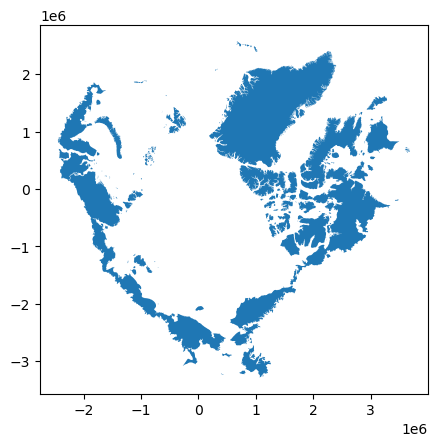

In [ ]:
cavm_outline = gpd.read_file("../../data/feature_layers/cavm_outline.gpkg")

In [139]:
# Filter VIIRS perimeters in Siberian tundra
fname_perims_in_cavm = "../../data/feature_layers/fire_atlas/viirs_perimeters_in_cavm_e113.gpkg"

if os.path.exists(fname_perims_in_cavm):
    print("CAVM Fire perimeter file exists, loading.")
    merged_fire_perimeters = gpd.read_file(fname_perims_in_cavm)
else:
    print("CAVM Fire perimeter file doesn't exist, processing.")
    gpkg_files = glob("../../data/feature_layers/fire_atlas/final_viirs*.gpkg")

    fire_perimeters = []
    for gpkg_file in gpkg_files:
        # Read the current GPKG file and append to the list
        gdf = gpd.read_file(gpkg_file)
        fire_perimeters.append(gdf)
    # concat to 1 df
    merged_fire_perimeters = gpd.GeoDataFrame(pd.concat(fire_perimeters, ignore_index=True))
    merged_fire_perimeters["UniqueID"] = range(len(merged_fire_perimeters))
    
    # extract fires east of 113°N (too many flase detections towards W Siberia with industry)
    fires_east = merged_fire_perimeters[merged_fire_perimeters.geometry.apply(lambda x: x.centroid.x > 113)]
    fires_east['centroid'] = fires_east.geometry.centroid
    
    # Extract centroids for intersection (faster and avoids holes in polygon intersections)
    fire_centroids = gpd.GeoDataFrame(fires_east[['UniqueID', 'centroid']], geometry='centroid')
    fire_centroids = fire_centroids.to_crs(cavm_outline.crs)
    
    centroids_within_cavm = gpd.overlay(fire_centroids, cavm_outline, how='intersection')

    # select perimeters in CAVM zone
    fire_within_cavm = fires_east[fires_east['UniqueID'].isin(centroids_within_cavm.UniqueID.values)]
    
    # export to file
    fire_within_cavm.iloc[:,:-1].to_file(fname_perims_in_cavm) # exclude "centroids" from export

CAVM Fire perimeter file exists, loading.


In [140]:
n_features = len(fire_within_cavm)

print(f"{n_features} fire scars within CAVM & east of 113° E")

n_years = len(fire_within_cavm.ted_year.unique())
print(f"{n_years} fire years in selection")


199 fire scars within CAVM & east of 113° E
12 fire years in selection


In [137]:
# fires_east.head()
fire_within_cavm.explore()

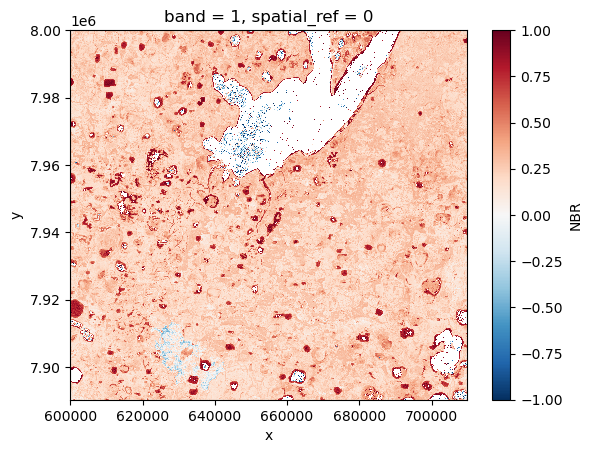

In [3]:
nbr_pre = rxr.open_rasterio("../../data/raster/hls/HLS.S30.T54WXE.2019256T022551.v2.0_NBR.tif")
nbr_pre.plot()

## Image stacking

In [3]:
# Find best UTM tile for the feature by identifying closest tile centroid to feature centroid
sindex = mgrs_tile_centroids.geometry.sindex.nearest(roi.geometry.centroid)
nearest_mgrs_tile_centroid = mgrs_tile_centroids.iloc[sindex[1],:] # Query tile in all MGRS tiles

tile_name = nearest_mgrs_tile_centroid.Name
tile_name

C:\Users\nrietze\AppData\Local\Temp\ipykernel_21328\1851750463.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sindex = mgrs_tile_centroids.geometry.sindex.nearest(roi.geometry.centroid)


51094    54WXE
Name: Name, dtype: object

In [4]:
HLS_DIR = '../../data/raster/hls/'

# List NBR COGs
nbr_files = [
    os.path.abspath(os.path.join(HLS_DIR, o)) 
    for o in os.listdir(HLS_DIR)  # list dir is not recursive, so dNBR subfolder will not be searched :)
    if o.endswith('NBR.tif') and tile_name.item() in o # find files that are in the tile and are NBR
    ] 

print(f"There are {len(nbr_files)} NBR files for this feature.")

def time_index_from_filenames(files):
    '''
    Helper function to create a pandas DatetimeIndex
    '''
    return [datetime.datetime.strptime(f.split('.')[-4], '%Y%jT%H%M%S') for f in files]

time = xr.Variable('time', time_index_from_filenames(nbr_files))

There are 9 NBR files for this feature.


In [5]:
chunks=dict(band=1, x=512, y=512)

nbr_ts = xr.concat([rxr.open_rasterio(f, mask_and_scale=True, chunks=chunks).squeeze('band', drop=True) for f in nbr_files], dim=time)
nbr_ts.name = 'NBR'

nbr_files

['c:\\Users\\nrietze\\Documents\\1_PhD\\10_CHAPTER3\\TundraPreFire\\data\\raster\\hls\\HLS.L30.T54WXE.2019256T022605.v2.0_NBR.tif',
 'c:\\Users\\nrietze\\Documents\\1_PhD\\10_CHAPTER3\\TundraPreFire\\data\\raster\\hls\\HLS.L30.T54WXE.2020254T020729.v2.0_NBR.tif',
 'c:\\Users\\nrietze\\Documents\\1_PhD\\10_CHAPTER3\\TundraPreFire\\data\\raster\\hls\\HLS.L30.T54WXE.2020256T015532.v2.0_NBR.tif',
 'c:\\Users\\nrietze\\Documents\\1_PhD\\10_CHAPTER3\\TundraPreFire\\data\\raster\\hls\\HLS.S30.T54WXE.2019254T023549.v2.0_NBR.tif',
 'c:\\Users\\nrietze\\Documents\\1_PhD\\10_CHAPTER3\\TundraPreFire\\data\\raster\\hls\\HLS.S30.T54WXE.2019255T025541.v2.0_NBR.tif',
 'c:\\Users\\nrietze\\Documents\\1_PhD\\10_CHAPTER3\\TundraPreFire\\data\\raster\\hls\\HLS.S30.T54WXE.2019256T022551.v2.0_NBR.tif',
 'c:\\Users\\nrietze\\Documents\\1_PhD\\10_CHAPTER3\\TundraPreFire\\data\\raster\\hls\\HLS.S30.T54WXE.2020254T023551.v2.0_NBR.tif',
 'c:\\Users\\nrietze\\Documents\\1_PhD\\10_CHAPTER3\\TundraPreFire\\data\\ra

In [6]:
nbr_ts = nbr_ts.sortby(nbr_ts.time)
nbr_ts

<xarray.DataArray 'NBR' (time: 9, y: 3660, x: 3660)>
dask.array<getitem, shape=(9, 3660, 3660), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6e+05 6e+05 6.001e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 8e+06 8e+06 8e+06 ... 7.89e+06 7.89e+06 7.89e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2019-09-11T02:35:49 ... 2020-09-12T02:...
Attributes:
    ACCODE:                    Lasrc; Lasrc
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    cloud_coverage:            0
    HLS_PROCESSING_TIME:       2021-12-21T03:28:13Z
    HORIZONTAL_CS_NAME:        UTM, WGS84, UTM ZONE 54; UTM, WGS84, UTM ZONE 54
    L1_PROCESSING_TIME:        2020-08-26T22:32:41Z; 2020-08-26T22:33:19Z
    LANDSAT_PRODUCT_ID:        LC08_L1TP_120009_20190913_20200826_02_T1; LC08...
    LANDSAT_SCENE_ID:          LC81200092019256LGN00; LC81200102019256LGN00
    long_name:                 NBR
    MEAN_SUN_AZIMUTH_ANGLE:    182.26204404472
    MEAN_SUN_ZENITH_ANGLE:     67.7334840754134
    MEAN_VIEW_AZIMUTH_ANGLE:   297.889254846992
    MEAN_VIEW_ZENITH_ANGLE:    6.29243999432371
    NBAR_SOLAR_ZENITH:         67.6558828213758
    NCOLS:                     3660
    NROWS:                     3660
    OVR_RESAMPLING_ALG:        NEAREST
    PROCESSING_LEVEL:          L1TP; L1TP
    SENSING_TIME:              2019-09-13T02:26:05.0890449Z; 2019-09-13T02:26...
    SENSOR:                    OLI_TIRS; OLI_TIRS
    SENTINEL2_TILEID:          54WXE
    spatial_coverage:          42
    SPATIAL_RESOLUTION:        30
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       600000
    ULY:                       8000040
    USGS_SOFTWARE:             LPGS_15.3.1c

Plot both available HLS tiles for Sep 13 2019 over the ROI

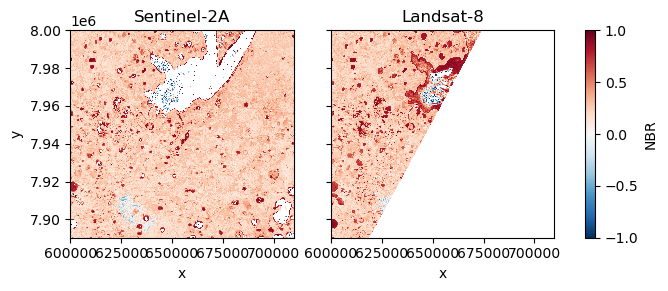

In [7]:
p1 = nbr_ts.sel(time = "2019-09-13").plot(col="time",col_wrap=2)

titles = ["Sentinel-2A", "Landsat-8"]

for ax, title in zip(p1.axes.flat, titles):
    ax.set_title(title)

Use maximum to composite the two scenes

c:\Users\nrietze\anaconda3\envs\pygeo\lib\site-packages\dask\array\reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Text(0.5, 1.0, 'Pre-fire Composite (13 Sep 2019)')

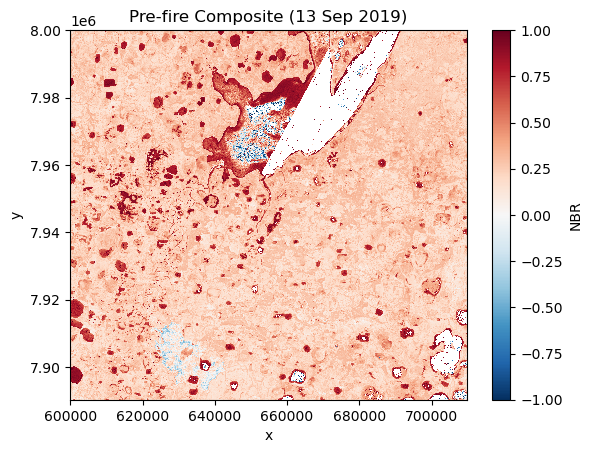

In [12]:
nbr_prefire_composite = nbr_ts.sel(time = "2019-09-13").max(dim = "time")

nbr_prefire_composite.plot()
plt.title("Pre-fire Composite (13 Sep 2019)")

Get post-fire data

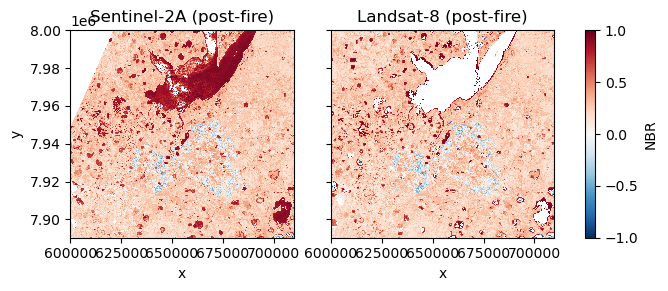

In [10]:
p1 = nbr_ts.sel(time = "2020-09-10").plot(col = "time",col_wrap = 2)

titles = ["Sentinel-2A (post-fire)", "Landsat-8 (post-fire)"]

for ax, title in zip(p1.axes.flat, titles):
    ax.set_title(title)

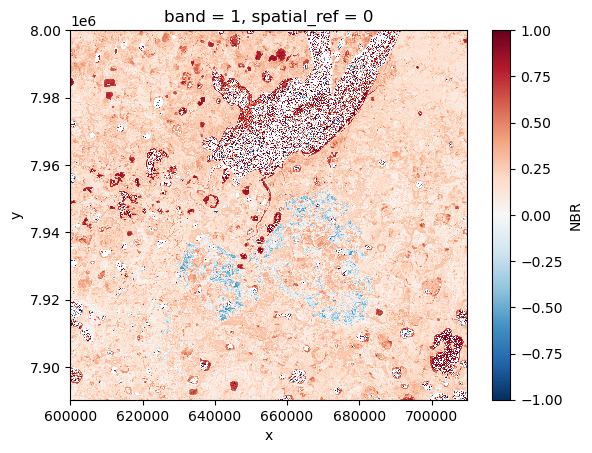

In [12]:
nbr_post = rxr.open_rasterio("../../data/raster/hls/HLS.S30.T54WXE.2020256T022549.v2.0_NBR.tif")
nbr_post.plot()

In [10]:
# create post-fire composite
nbr_postfire_composite = nbr_ts.sel(time = "2020-09-10").max(dim = "time")

<xarray.DataArray 'NBR' (time: 2, y: 3660, x: 3660)>
dask.array<getitem, shape=(2, 3660, 3660), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 6e+05 6e+05 6.001e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 8e+06 8e+06 8e+06 ... 7.89e+06 7.89e+06 7.89e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2020-09-10T02:07:29 2020-09-10T02:35:51
Attributes:
    ACCODE:                    Lasrc; Lasrc
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    cloud_coverage:            0
    HLS_PROCESSING_TIME:       2021-12-21T03:28:13Z
    HORIZONTAL_CS_NAME:        UTM, WGS84, UTM ZONE 54; UTM, WGS84, UTM ZONE 54
    L1_PROCESSING_TIME:        2020-08-26T22:32:41Z; 2020-08-26T22:33:19Z
    LANDSAT_PRODUCT_ID:        LC08_L1TP_120009_20190913_20200826_02_T1; LC08...
    LANDSAT_SCENE_ID:          LC81200092019256LGN00; LC81200102019256LGN00
    long_name:                 NBR
    MEAN_SUN_AZIMUTH_ANGLE:    182.26204404472
    MEAN_SUN_ZENITH_ANGLE:     67.7334840754134
    MEAN_VIEW_AZIMUTH_ANGLE:   297.889254846992
    MEAN_VIEW_ZENITH_ANGLE:    6.29243999432371
    NBAR_SOLAR_ZENITH:         67.6558828213758
    NCOLS:                     3660
    NROWS:                     3660
    OVR_RESAMPLING_ALG:        NEAREST
    PROCESSING_LEVEL:          L1TP; L1TP
    SENSING_TIME:              2019-09-13T02:26:05.0890449Z; 2019-09-13T02:26...
    SENSOR:                    OLI_TIRS; OLI_TIRS
    SENTINEL2_TILEID:          54WXE
    spatial_coverage:          42
    SPATIAL_RESOLUTION:        30
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       600000
    ULY:                       8000040
    USGS_SOFTWARE:             LPGS_15.3.1c

c:\Users\nrietze\anaconda3\envs\pygeo\lib\site-packages\dask\array\reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


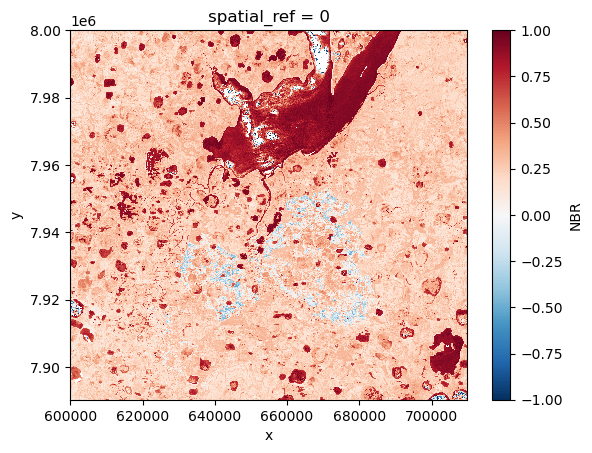

In [11]:
nbr_postfire_composite.plot()

c:\Users\nrietze\anaconda3\envs\pygeo\lib\site-packages\dask\array\reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


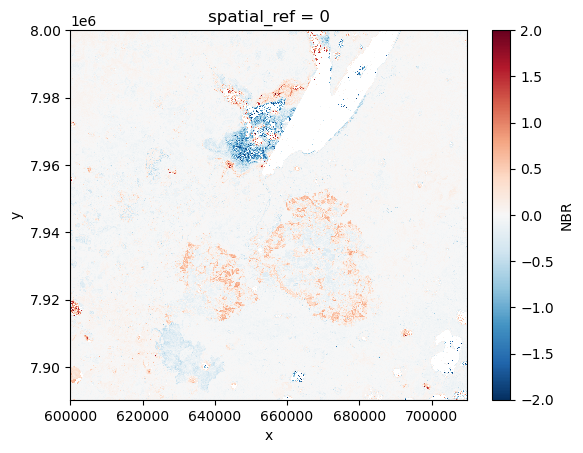

In [13]:
# calculate dNBR (pre - post fire)
dnbr = nbr_prefire_composite - nbr_postfire_composite

dnbr.plot()

Export dNBR raster

In [26]:
outName = os.path.join(HLS_DIR,
                       "dNBR", # store in separate subfolder
                       "2020_dNBR.tif")
outName

'../../data/raster/hls/dNBR\\2020_dNBR.tif'

In [27]:
# Open newly created GeoTIFF, add tiling, compression, and export as COG
dnbr.rio.to_raster(raster_path = outName, driver = 'COG')

c:\Users\nrietze\anaconda3\envs\pygeo\lib\site-packages\dask\array\reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Extract data within fire perimeters (Scholten fire atlas)

# Generate pre-fire time series

In [ ]:
HLS_DIR = '../../data/raster/hls/'

# List NDMI COGs
ndmi_files = [
    os.path.abspath(os.path.join(HLS_DIR, o)) 
    for o in os.listdir(HLS_DIR)  # list dir is not recursive, so dNBR subfolder will not be searched :)
    if o.endswith('NDMI_cropped.tif') and tile_name.item() in o # find files that are in the tile and are NBR
    ] 

print(f"There are {len(ndmi_files)} NDMI files for this feature.")

def time_index_from_filenames(files):
    '''
    Helper function to create a pandas DatetimeIndex
    '''
    return [datetime.datetime.strptime(f.split('.')[-4], '%Y%jT%H%M%S') for f in files]

time = xr.Variable('time', time_index_from_filenames(ndmi_files))

chunks=dict(band=1, x=512, y=512)

ndmi_ts = xr.concat([rxr.open_rasterio(f, mask_and_scale=True, chunks=chunks).squeeze('band', drop=True) for f in ndmi_files], dim=time)
ndmi_ts.name = 'NDMI'



In [ ]:
ndmi_ts.sum(dim = "time").plot(vmin = -1,vmax = 1)